# Аугментация

In [21]:
import albumentations as alb
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def gen_aug(index, sub_index):
    img = cv2.imread(f'input\img\image{index}.jpg')
    mask = cv2.imread(f'input\mask\mask{index}.jpg')
    
    # Создание объекта аугментации
    transform = alb.Compose([
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Affine(translate_percent={"x": 0.1, "y": 0.1}, rotate=(-45, 45), scale=(0.8, 1.2), p=1.0),
        alb.RandomScale(scale_limit=0.1, p=0.5), 
        alb.RandomCrop(height=300, width=300, p=0.5), 
        alb.RandomBrightnessContrast(p=0.4),
        alb.Blur(blur_limit=3, p=0.3),
    ])

    # Применение аугментации к изображению
    augmented_i = transform(image=img, mask=mask)
    # augmented_m = transform(image=mask)
    
    # Получение аугментированного изображения
    augmented_image = augmented_i['image']
    augmented_mask = augmented_i['mask']
    
    resized_image = cv2.resize(augmented_image, (300, 300))
    resized_mask = cv2.resize(augmented_mask, (300, 300))

    # Сохранение аугментированного изображения
    cv2.imwrite(f'augment/img/augmented_image_{index}_{sub_index}.jpg', resized_image)
    cv2.imwrite(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', resized_mask)

In [23]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [24]:
count_aug = 10
for i in range(2):
    for num in range(count_aug):
        gen_aug(i, num)

# Машиночитаемый вид

In [25]:
import numpy as np

In [26]:
def get_machine_img(index, sub_index):    
    img = cv2.imread(f'augment/img/augmented_image_{index}_{sub_index}.jpg')
    mask = cv2.imread(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', cv2.IMREAD_GRAYSCALE)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, (300, 300))
    
    norm_img = img / 255.0
    # mask = cv2.resize(mask, (300, 300))
    norm_mask = (mask > 0).astype(np.float32) # бинаризация
    return (norm_img, norm_mask.reshape(300, 300, 1))
    

In [27]:
mass_img = []
mass_mask = [] 
for i in range(2):
    for num in range(count_aug):
        img, mask = get_machine_img(i, num)
        print(i, num, img.shape, mask.shape)
        mass_img.append(img), mass_mask.append(mask)
mass_img = np.array(mass_img)
mass_mask = np.array(mass_mask) 

0 0 (300, 300, 3) (300, 300, 1)
0 1 (300, 300, 3) (300, 300, 1)
0 2 (300, 300, 3) (300, 300, 1)
0 3 (300, 300, 3) (300, 300, 1)
0 4 (300, 300, 3) (300, 300, 1)
0 5 (300, 300, 3) (300, 300, 1)
0 6 (300, 300, 3) (300, 300, 1)
0 7 (300, 300, 3) (300, 300, 1)
0 8 (300, 300, 3) (300, 300, 1)
0 9 (300, 300, 3) (300, 300, 1)
1 0 (300, 300, 3) (300, 300, 1)
1 1 (300, 300, 3) (300, 300, 1)
1 2 (300, 300, 3) (300, 300, 1)
1 3 (300, 300, 3) (300, 300, 1)
1 4 (300, 300, 3) (300, 300, 1)
1 5 (300, 300, 3) (300, 300, 1)
1 6 (300, 300, 3) (300, 300, 1)
1 7 (300, 300, 3) (300, 300, 1)
1 8 (300, 300, 3) (300, 300, 1)
1 9 (300, 300, 3) (300, 300, 1)


# Создание модели

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Полносвязная нейронная сеть

In [29]:
from tensorflow import keras

In [30]:
mass_img[0].shape, mass_mask[0].shape

((300, 300, 3), (300, 300, 1))

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
x_t, x_v, y_t, y_v = train_test_split(mass_img, mass_mask, test_size=0.25, random_state=42)

In [33]:
x_t.shape

(15, 300, 300, 3)

In [34]:
# Создаем модель
model = keras.Sequential([
    # keras.layers.Input(shape=(x_t[0].shape)),
    keras.layers.Flatten(input_shape=(300, 300, 3)),
    keras.layers.Dense(1200, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(300 * 300, activation='sigmoid'),
    keras.layers.Reshape((300, 300, 1))
])

In [35]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision'])

In [36]:
# Обучаем модель
hst = model.fit(x=x_t, y=y_t, validation_data=(x_v, y_v), epochs=40, batch_size=15)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.4999 - loss: 0.6935 - precision: 0.6993 - val_accuracy: 0.6382 - val_loss: 0.6540 - val_precision: 0.7638
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6396 - loss: 0.6528 - precision: 0.7824 - val_accuracy: 0.7743 - val_loss: 0.8737 - val_precision: 0.8351
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7748 - loss: 0.7881 - precision: 0.8510 - val_accuracy: 0.7416 - val_loss: 0.5245 - val_precision: 0.8106
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7456 - loss: 0.5031 - precision: 0.8290 - val_accuracy: 0.7733 - val_loss: 0.4535 - val_precision: 0.8281
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7756 - loss: 0.4427 - precision: 0.8448 - val_accuracy: 0.7965 - val_loss: 0.4202 - val_precision: 0.8414
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7997 - loss: 0.4012 - precision: 0.8585 - val_accuracy: 0.8231 - val_loss: 0.3804 - val_precision: 0.8

In [37]:
model.predict(x_v)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


array([[[[1.55726141e-22],
         [1.51150341e-23],
         [5.70248903e-21],
         ...,
         [3.05565071e-16],
         [3.08787338e-13],
         [1.05502530e-10]],

        [[6.34519638e-23],
         [1.72879992e-24],
         [1.51668531e-22],
         ...,
         [5.50612031e-15],
         [5.14490421e-14],
         [6.55745769e-09]],

        [[1.55225036e-21],
         [5.57927871e-22],
         [5.64740789e-24],
         ...,
         [1.37536273e-16],
         [5.05807527e-13],
         [1.22737020e-12]],

        ...,

        [[2.34656090e-05],
         [5.27291326e-04],
         [5.66439157e-05],
         ...,
         [3.02861095e-04],
         [1.05826010e-04],
         [2.71625213e-05]],

        [[4.45287791e-04],
         [3.17946565e-03],
         [4.44772048e-03],
         ...,
         [4.37628114e-06],
         [4.51848563e-03],
         [1.02278102e-06]],

        [[1.67645526e-03],
         [8.50088545e-05],
         [1.63539971e-05],
         ...,
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


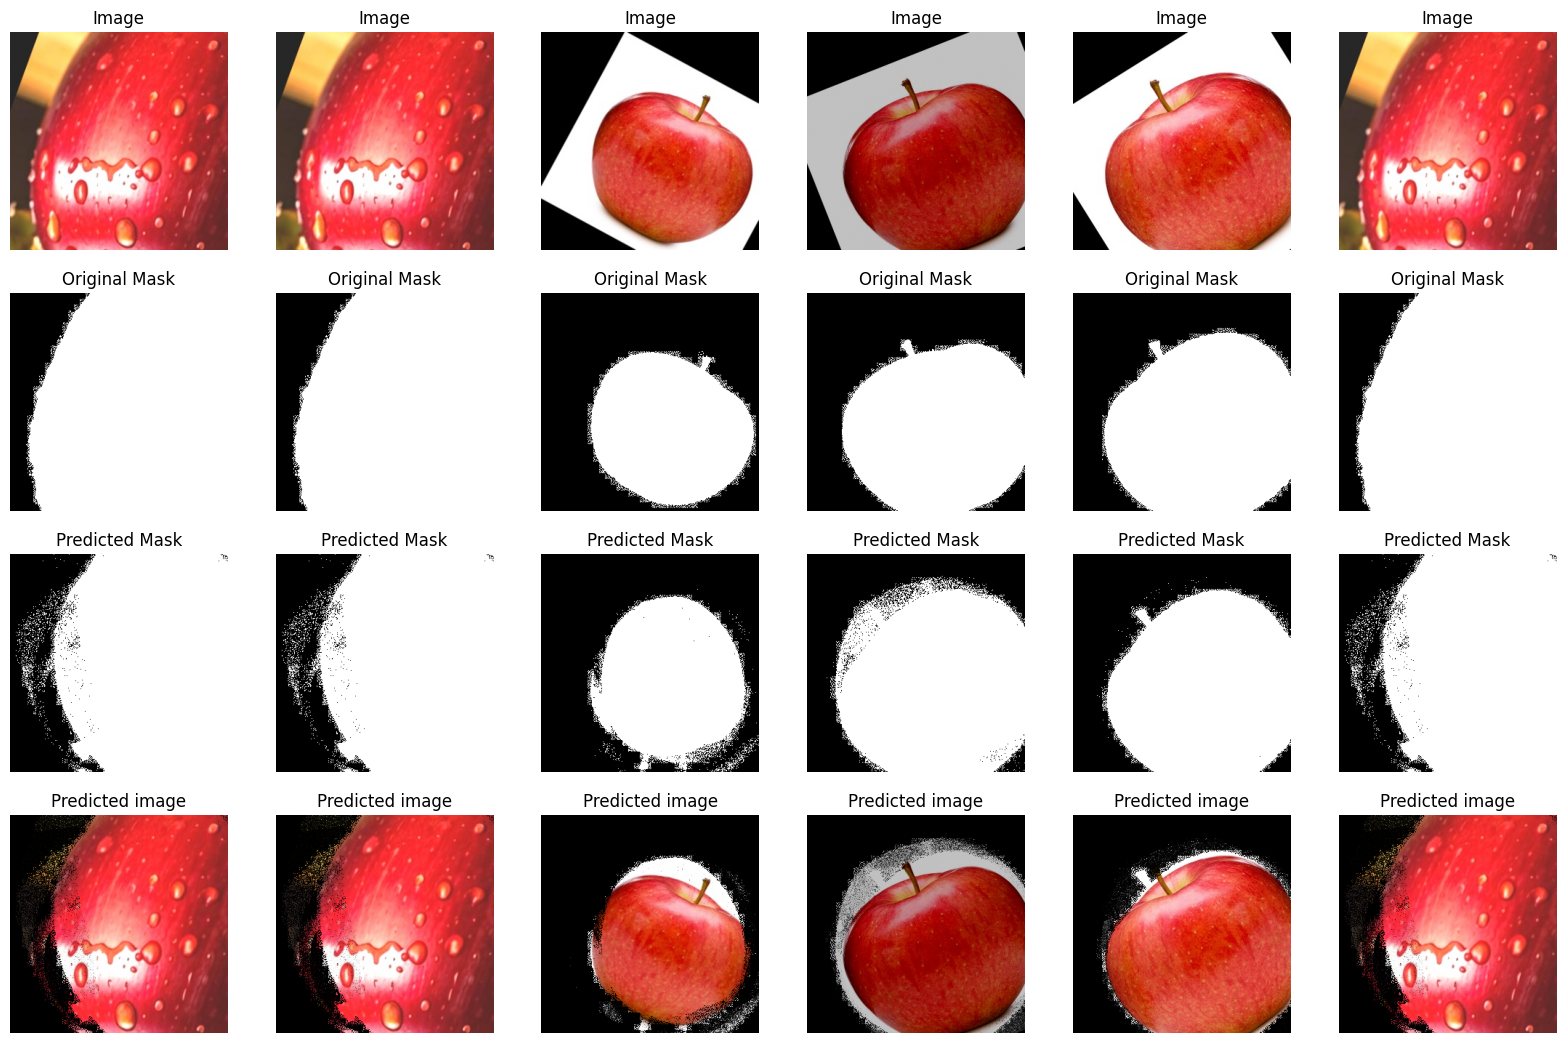

In [38]:
plot_results(x_v, y_v, model.predict(x_v), 2 * 3)

In [39]:
def plot_hist(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # График точности
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision during training')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.show()


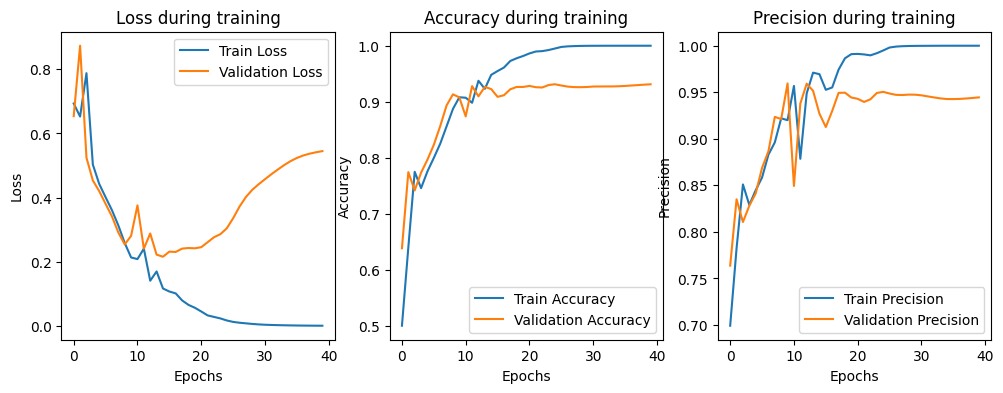

In [40]:
plot_hist(hst)